In [4]:
pip install ternary


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for ternary: filename=ternary-0.1-py3-none-any.whl size=1752 sha256=12edeeeea7971a56cef64707891e6294a806c60186e74fac89d02168174ee99b
  Stored in directory: /Users/k23070952/Library/Caches/pip/wheels/d7/6e/54/60848f233a06e5db63831ed34cf4210628ba15030f8b6b4fa3
Successfully built ternary

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import biosteam as bst
bst.nbtutorial() # For light-mode diagrams, ignore warnings

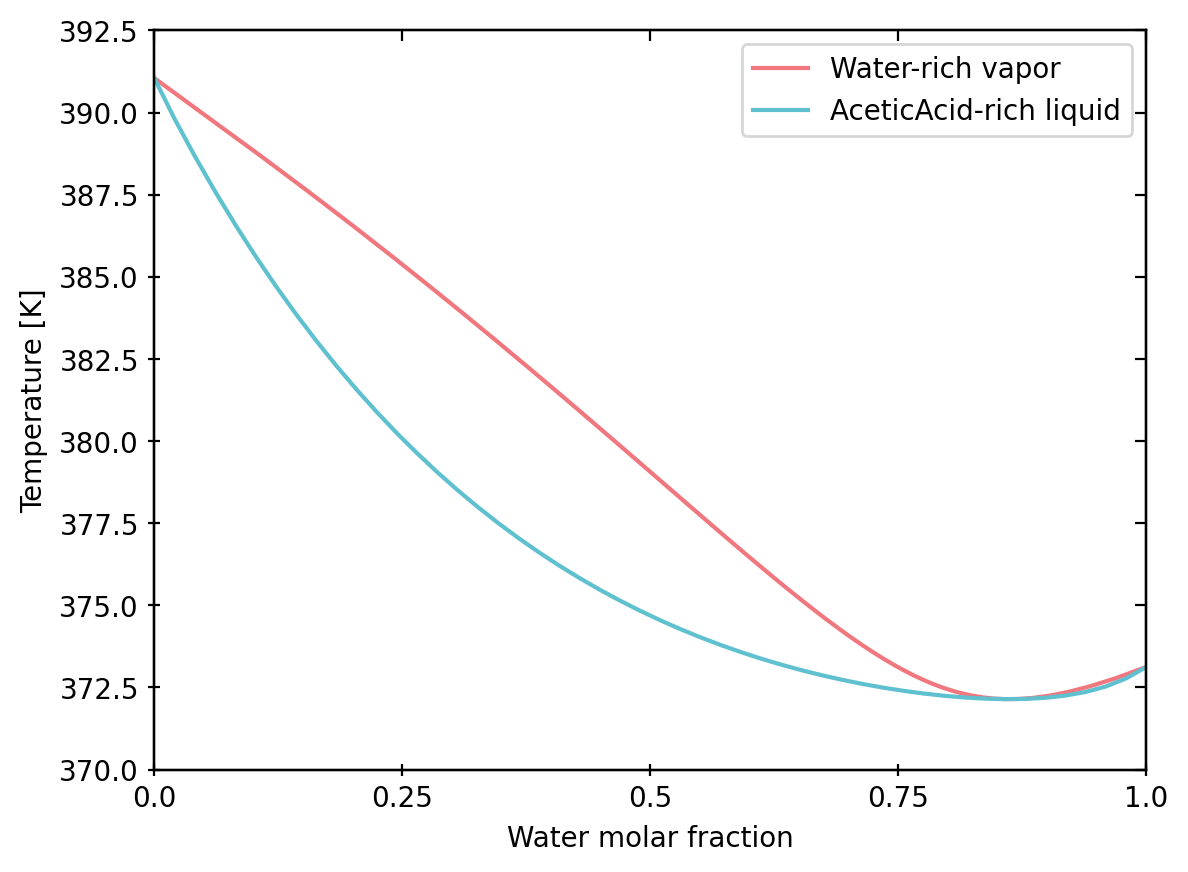

In [5]:
bst.plot_vle_binary_phase_envelope(['Water', 'AceticAcid'], P=101325)

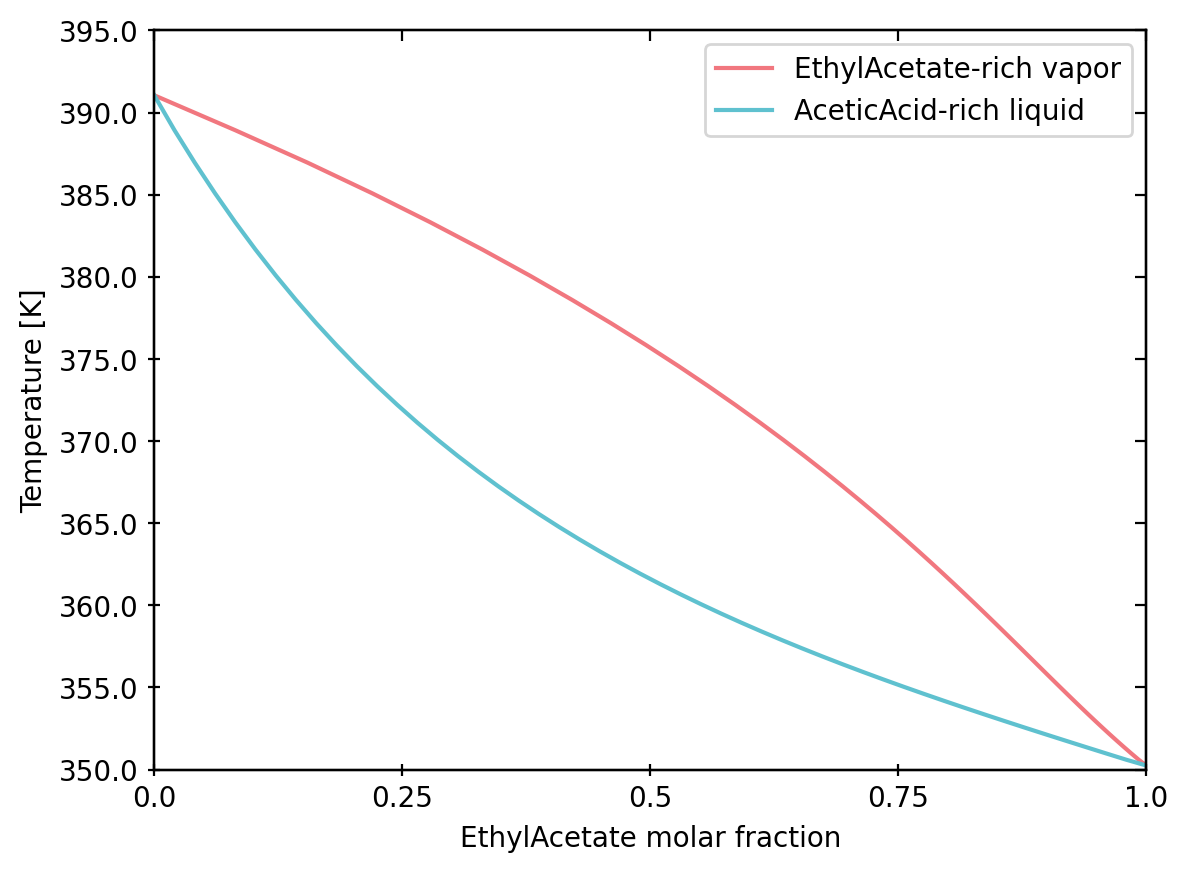

In [7]:
bst.plot_vle_binary_phase_envelope(['EthylAcetate', 'AceticAcid'], P=101325)

In [24]:
for i in bst.Chemicals(['Water', 'EthylAcetate', 'AceticAcid']): print(i, round(i.Tb, 2), 'K')

Water 373.12 K
EthylAcetate 350.25 K
AceticAcid 391.05 K


In [35]:
# Define chemicals used in the process
bst.settings.set_thermo(['Water', 'AceticAcid', 'EthylAcetate'])

# Amount of ethyl-acetate to fermentation broth
solvent_feed_ratio = 1.5

# Fermentation broth with dilute acetic acid
acetic_acid_broth = bst.Stream(ID='acetic_acid_broth', AceticAcid=1000, Water=9000, units='kg/hr')

# Solvent
ethyl_acetate = bst.Stream(ID='ethyl_acetate',  EthylAcetate=1)

# Products
glacial_acetic_acid = bst.Stream(ID='glacial_acetic_acid')
wastewater = bst.Stream(ID='wastewater')

# Recycles
solvent_recycle = bst.Stream('solvent_rich')
water_rich = bst.Stream('water_rich')
distillate = bst.Stream('raffinate_distillate')

# System and unit operations
with bst.System('AAsep') as sys:
    extractor = bst.MultiStageMixerSettlers(
        'extractor',
        ins=(acetic_acid_broth, ethyl_acetate, solvent_recycle),
        outs=('extract', 'raffinate'),
        top_chemical='EthylAcetate',
        feed_stages=(0, -1, -1),
        N_stages=12,
        use_cache=True,
    )

    @extractor.add_specification(run=True)
    def adjust_fresh_solvent_flow_rate():
        broth = acetic_acid_broth.F_mass
        EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        EtAc_required = broth * solvent_feed_ratio
        if EtAc_required < EtAc_recycle:
            solvent_recycle.F_mass *= EtAc_required / EtAc_recycle
            EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        EtAc_fresh = EtAc_required - EtAc_recycle
        ethyl_acetate.imass['EthylAcetate'] = max(
            0, EtAc_fresh
        )

    HX = bst.HXutility(
        'extract_heater',
        ins=(extractor.extract),
        outs=('hot_extract'),
        rigorous=True,
        V=0,
    )
    ED = bst.ShortcutColumn(
        'extract_distiller',
        ins=HX-0,
        outs=['', 'acetic_acid'],
        LHK=('Water', 'AceticAcid'),
        Lr=0.95,
        Hr=0.95,
        k=1.4,
        partial_condenser=False,
    )
    ED2 = bst.ShortcutColumn(
        'acetic_acid_purification',
        ins=ED-1,
        outs=('', glacial_acetic_acid),
        LHK=('EthylAcetate', 'AceticAcid'),
        Lr=0.999,
        Hr=0.999,
        k=1.4,
        partial_condenser=False
    )
    ED.check_LHK = ED2.check_LHK = False
    mixer = bst.Mixer(
        ins=(ED-0, ED2-0, distillate)
    )
    HX = bst.HXutility(ins=mixer-0, T=310)
    settler = bst.MixerSettler(
        'settler',
        ins=HX-0,
        outs=(solvent_recycle, water_rich),
        top_chemical='EthylAcetate',
    )
    mixer = bst.Mixer(ins=[extractor.raffinate, water_rich])
    RD = bst.ShortcutColumn(
        'raffinate_distiller',
        LHK=('EthylAcetate', 'Water'),
        ins=mixer-0,
        outs=[distillate, wastewater],
        partial_condenser=False,
        Lr=0.99,
        Hr=0.99,
        k=1.5,
    )

sys.simulate()
sys.diagram(kind='cluster', format='png')
sys.show()

System: AAsep
Highest convergence error among components in recycle
stream H7-0 after 2 loops:
- flow rate   4.90e-01 kmol/hr (1.2%)
- temperature 0.00e+00 K (0%)
ins...
[0] acetic_acid_broth  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water       500
                    AceticAcid  16.7
[1] ethyl_acetate  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): EthylAcetate  0.225
outs...
[0] wastewater  
    phase: 'l', T: 372.37 K, P: 101325 Pa
    flow (kmol/hr): Water         499
                    AceticAcid    2.75
                    EthylAcetate  0.0853
[1] glacial_acetic_acid  
    phase: 'l', T: 390.75 K, P: 101325 Pa
    flow (kmol/hr): Water         0.000126
                    AceticAcid    13.9
                    EthylAcetate  0.0352


In [26]:
sys.operating_hours = 330 * 24
print('CAPEX', round(sys.installed_equipment_cost / 1e6, 3), 'MMUSD')
print('OPEX', round(sys.material_cost + sys.utility_cost / 1e6, 4), 'MMUSD/yr')

CAPEX 1.752 MMUSD
OPEX 0.8838 MMUSD/yr


In [36]:
print(ED.results())
outlet = ED.reboiler.outs[0]
boilup = outlet['g'].F_mol / outlet['l'].F_mol
distillate, condensate = ED.top_split.outs
split = condensate.F_mol / ED.condenser.outs[0].F_mol # Or from ED.design_results['Reflux']
N_stages = int(ED.design_results['Theoretical stages'])
feed_stage = int(ED.design_results['Theoretical feed stage'])

Distillation Column                              Units  extract_distiller
Electricity         Power                           kW               1.62
                    Cost                        USD/hr              0.127
Cooling water       Duty                         kJ/hr          -7.78e+06
                    Flow                       kmol/hr           5.31e+03
                    Cost                        USD/hr               2.59
Low pressure steam  Duty                         kJ/hr           8.21e+06
                    Flow                       kmol/hr                212
                    Cost                        USD/hr               50.4
Design              Theoretical feed stage                              7
                    Theoretical stages                                 10
                    Minimum reflux               Ratio              0.268
                    Reflux                       Ratio              0.376
                    Actual stages     

In [28]:
print(boilup, distillate, split, N_stages, feed_stage)

4.3938708104276465 s36 0.27309012898098783 10 7


In [29]:
acetic_acid_broth = bst.Stream(ID='acetic_acid_broth', AceticAcid=1000, Water=9000, units='kg/hr')
print(acetic_acid_broth)

acetic_acid_broth


In [37]:
acetic_acid_broth

Stream: acetic_acid_broth to <MultiStageMixerSettlers: extractor>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water       500
                AceticAcid  16.7


In [39]:
acetic_acid_broth.F_mass

10000.0

In [40]:
reflux = bst.Stream('reflux')

# Amount of ethyl-acetate to fermentation broth
solvent_feed_ratio = 1.5

reflux = bst.Stream('reflux')
# Fermentation broth with dilute acetic acid
acetic_acid_broth = bst.Stream(ID='acetic_acid_broth', AceticAcid=1000, Water=9000, units='kg/hr')
print(acetic_acid_broth)

# Solvent
ethyl_acetate = bst.Stream(ID='ethyl_acetate',  EthylAcetate=1)

# Products
glacial_acetic_acid = bst.Stream(ID='glacial_acetic_acid')
wastewater = bst.Stream(ID='wastewater')

# Recycles
solvent_recycle = bst.Stream('solvent_rich')
water_rich = bst.Stream('water_rich')


# System and unit operations
with bst.System('AAsep') as sys:
    extractor = bst.MultiStageMixerSettlers(
        'extractor',
        ins=(acetic_acid_broth, ethyl_acetate, solvent_recycle),
        outs=('extract', 'raffinate'),
        top_chemical='EthylAcetate',
        feed_stages=(0, -1, -1),
        N_stages=12,
        use_cache=True,
    )

    @extractor.add_specification(run=True)
    def adjust_fresh_solvent_flow_rate():
        broth = acetic_acid_broth.F_mass
        EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        EtAc_required = broth * solvent_feed_ratio
        if EtAc_required < EtAc_recycle:
            solvent_recycle.F_mass *= EtAc_required / EtAc_recycle
            EtAc_recycle = solvent_recycle.imass['EthylAcetate']
        EtAc_fresh = EtAc_required - EtAc_recycle
        ethyl_acetate.imass['EthylAcetate'] = max(
            0, EtAc_fresh
        )
        print(acetic_acid_broth.F_mass, solvent_recycle.imass['EthylAcetate'], acetic_acid_broth.F_mass * solvent_feed_ratio, EtAc_required - EtAc_recycle)

    HX = bst.HXutility(
        'extract_heater',
        ins=(extractor.extract),
        outs=('hot_extract'),
        rigorous=True,
        V=0,
    )
    ED = bst.MESHDistillation(
        'extract_distiller',
        ins=(HX-0, reflux),
        outs=('', 'acetic_acid', 'distillate'),
        feed_stages=[feed_stage-2, 1],
        N_stages=N_stages,
        full_condenser=True,
        boilup=boilup,
        LHK=('Water', 'AceticAcid'),
        use_cache=True,
    )
    ED2 = bst.ShortcutColumn(
        'acetic_acid_purification',
        ins=ED-1,
        outs=('', glacial_acetic_acid),
        LHK=('EthylAcetate', 'AceticAcid'),
        Lr=0.999,
        Hr=0.999,
        k=1.4,
        partial_condenser=False
    )
    ED.check_LHK = ED2.check_LHK = False
    mixer = bst.Mixer(
        ins=(ED-2, ED2-0, distillate)
    )
    HX = bst.HXutility(ins=mixer-0, T=310)
    settler = bst.MixerSettler(
        'settler',
        ins=HX-0,
        outs=('', water_rich),
        top_chemical='EthylAcetate',
    )
    splitter = bst.Splitter(
        'splitter',
        ins=settler-0,
        outs=(reflux, solvent_recycle),
        split=split,
    )
    mixer = bst.Mixer(ins=[extractor.raffinate, water_rich])
    RD = bst.ShortcutColumn(
        'raffinate_distiller',
        LHK=('EthylAcetate', 'Water'),
        ins=mixer-0,
        outs=[distillate, wastewater],
        partial_condenser=False,
        Lr=0.99,
        Hr=0.99,
        k=1.5,
    )
sys.set_tolerance(rmol=1e-3, mol=1e-3, subsystems=True)
sys.simulate()
sys.diagram(format='png')
sys.show()

acetic_acid_broth
10000.0 0.0 15000.0 15000.0
10000.0 515.0600957892474 15000.0 14484.939904210753
10000.0 0.0 15000.0 15000.0
10000.0 15000.000000000002 15000.0 -1.8189894035458565e-12
10000.0 15000.0 15000.0 0.0
10000.0 14994.001857375712 15000.0 5.998142624288448
10000.0 14982.797768173947 15000.0 17.20223182605332
10000.0 14989.043173084678 15000.0 10.956826915322381
System: AAsep
Highest convergence error among components in recycle
streams {extract_distiller-2, acetic_acid_purification-0, splitter-1, settler-1} after 8 loops:
- flow rate   4.32e-03 kmol/hr (0.034%)
- temperature 1.27e-05 K (3.7e-06%)
ins...
[0] acetic_acid_broth  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water       500
                    AceticAcid  16.7
[1] ethyl_acetate  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): EthylAcetate  0.124
outs...
[0] wastewater  
    phase: 'l', T: 372.38 K, P: 101325 Pa
    flow (kmol/hr): Water         500
                    AceticAcid   

In [41]:
sys.operating_hours = 330 * 24
print('CAPEX', round(sys.installed_equipment_cost / 1e6, 3), 'MMUSD')
print('OPEX', round(sys.material_cost + sys.utility_cost / 1e6, 3), 'MMUSD/yr')

CAPEX 1.807 MMUSD
OPEX 0.963 MMUSD/yr
